Removing Inconsistencies In Concrete COmpressive Strength using Machine Learning Algorithms

Importing Libraries

In [78]:
%matplotlib inline
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression,TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error,mean_squared_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import cross_val_score
import seaborn
from IPython.display import Image

In [79]:
data = pd.read_csv('C:/Users/LTD/Desktop/Passion/Pyhton_ML_Projects/Concrete_Data.csv')
print (len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [80]:
data.columns = ['cement_component', 'furnace_slag', 'flay_ash',
'water_component', 'superplasticizer', \
'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']
data.head()

,cement_component,furnace_slag,flay_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


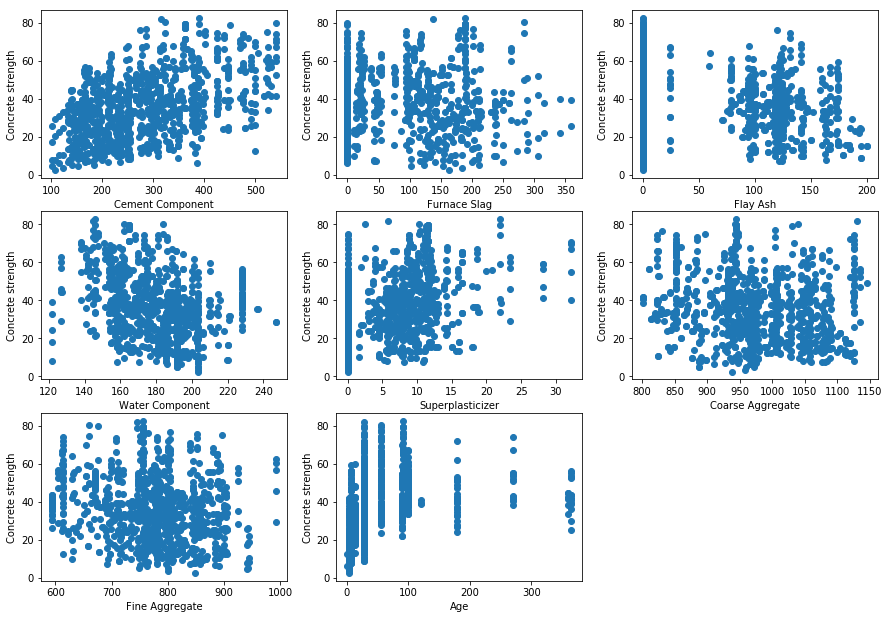

In [81]:
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature], data['concrete_strength'])
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    plot_count+=1
plt.show()

In [82]:
#Creating Pairwise Pearson Correlation
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  flay_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275    -0.397           -0.082             0.092   
furnace_slag                 -0.275         1.000    -0.324            0.107             0.043   
flay_ash                     -0.397        -0.324     1.000           -0.257             0.378   
water_component              -0.082         0.107    -0.257            1.000            -0.658   
superplasticizer              0.092         0.043     0.378           -0.658             1.000   
coarse_aggregate             -0.109        -0.284    -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282     0.079           -0.451             0.223   
age                           0.082        -0.044    -0.154            0.278            -0.193   
concrete_strength             0.498         0.135    -0.106           -0.290             0.366   

                   

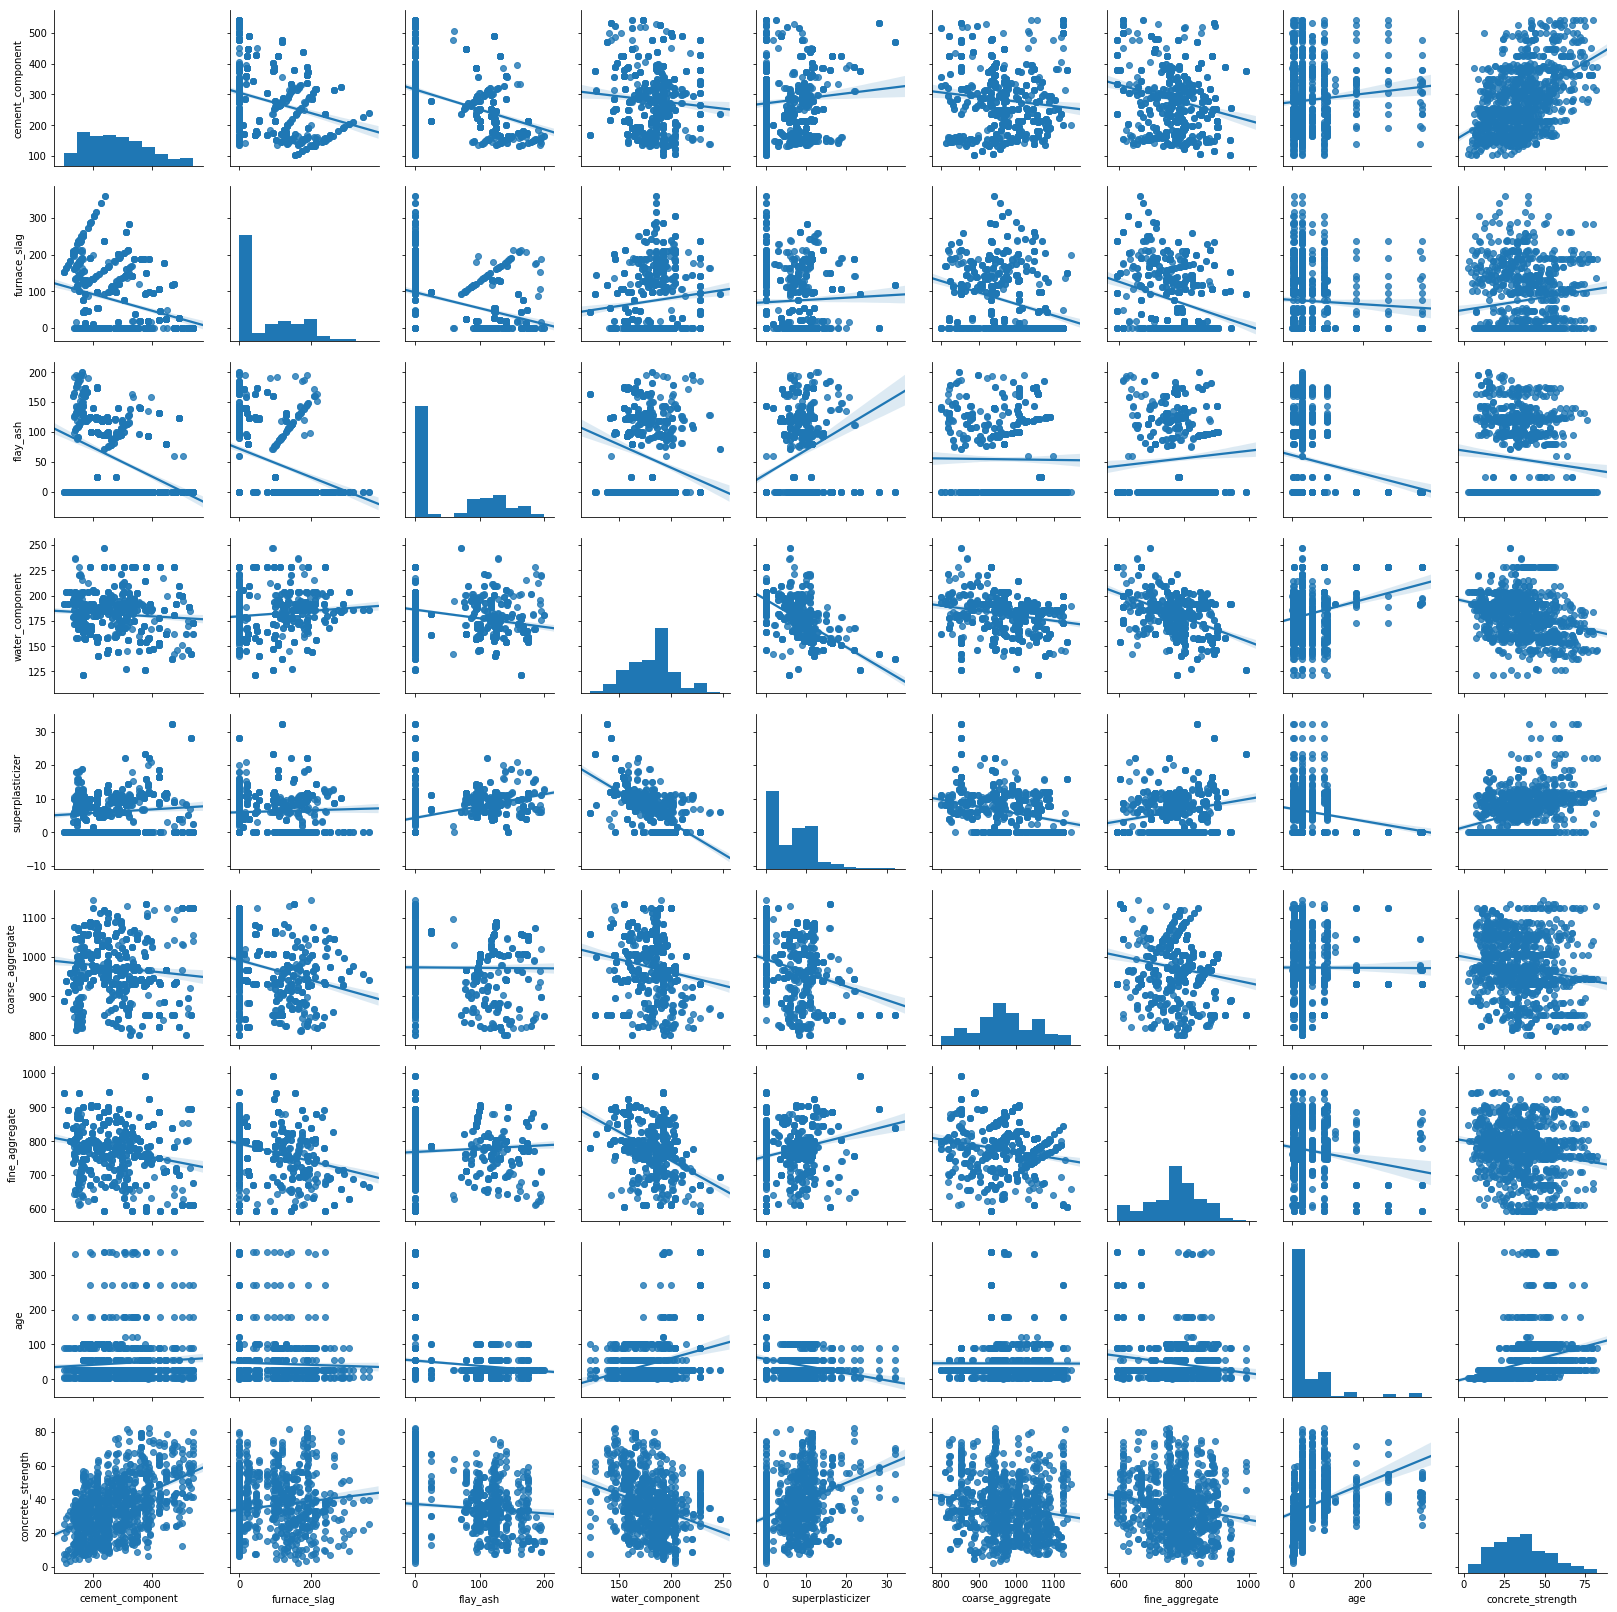

In [83]:
#Calculating Pair Plot Between All Features
data_ = data[(data.T != 0).any()]
seaborn. pairplot(data_, vars=data.columns, kind='reg')
plt.show()

In [84]:
#Splitting the Data in Training and Testing sets
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size = 1-train_index)
    if type(feature) == list:
        x_train = train[feature].as_matrix()
        y_train = train['concrete_strength'].as_matrix()
        x_test = test[feature].as_matrix()
        y_test = test['concrete_strength'].as_matrix()
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
    return x_train, y_train, x_test, y_test

cement_component 0.2117851768563922
flay_ash 0.006288126897640134
water_component 0.11619324029319811
superplasticizer 0.10045353119330724
coarse_aggregate 0.010618303688307185


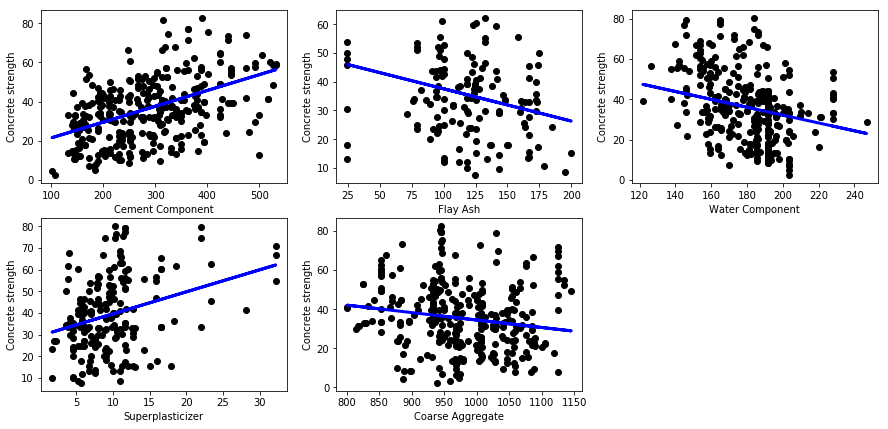

In [85]:
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature) 
    # Create linear regression object
    regr = LinearRegression()
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Create linear regression object
    regr = LinearRegression()
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue',linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.197392
Intercept: 56.145105
Coefficients: [ 0.04150687 -0.04170566 -0.10525394  0.30684244 -0.00851701]


C:\Users\LTD\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\LTD\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\LTD\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\LTD\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


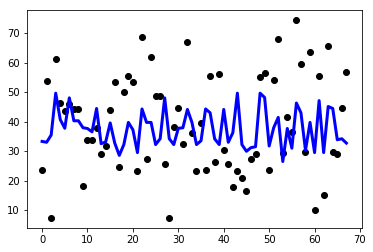

In [86]:
features = ['cement_component', 'flay_ash', 'water_component',
'superplasticizer', 'coarse_aggregate']
data_tr = data
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, features)
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.197408
Intercept: 56.145105
Coefficients: [ 0.04150687 -0.04170566 -0.10525394  0.30684244 -0.00851701]


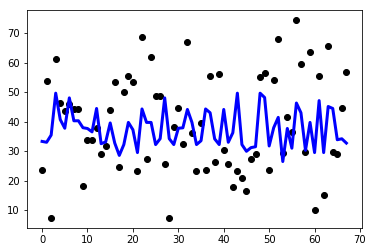

In [92]:
#Calculating Multiple Ridge Regression
alphas = np.arange(0.1,5,0.1)
model = Ridge()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.197795
Intercept: 56.145105
Coefficients: [ 0.04150687 -0.04170566 -0.10525394  0.30684244 -0.00851701]


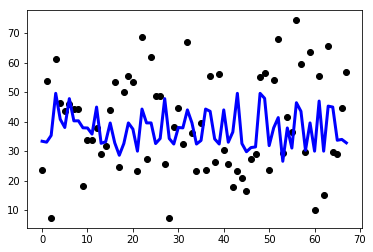

In [91]:
#Calculating Multiple Lasso Regression
model = Lasso()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.197922
Intercept: 56.145105
Coefficients: [ 0.04150687 -0.04170566 -0.10525394  0.30684244 -0.00851701]


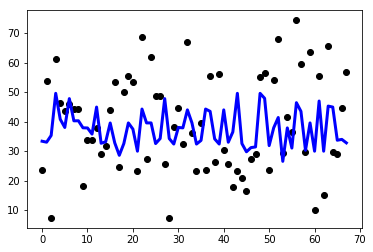

In [94]:
model = ElasticNet()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_prede = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_prede))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

cement_component 0.319865511615549
flay_ash 0.07844949195050654
water_component 0.38703409147418444
superplasticizer 0.18034297568345958
coarse_aggregate 0.2444002316833268


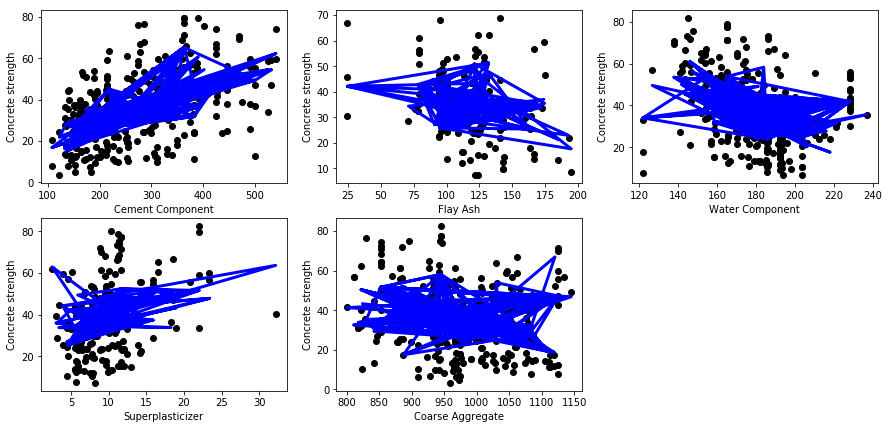

In [97]:
#Calculating Single Gradient Boosting Regression
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    # Create linear regression object
    regr = GradientBoostingRegressor()
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue',linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']


C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Found input variables with inconsistent numbers of samples: [310, 68]

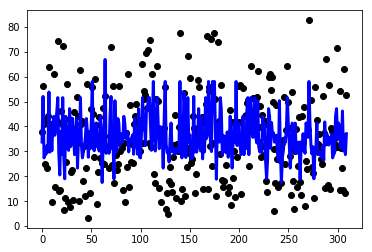

In [99]:
# Calculating Multiple Gradient Boosting Regression
model = GradientBoostingRegressor()
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue',linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_prede))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))

C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.23514147463827995
flay_ash 0.02949565508422969
water_component 0.061491235983639814
superplasticizer 0.048983039861354105


C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


coarse_aggregate -0.017503170069284035


C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


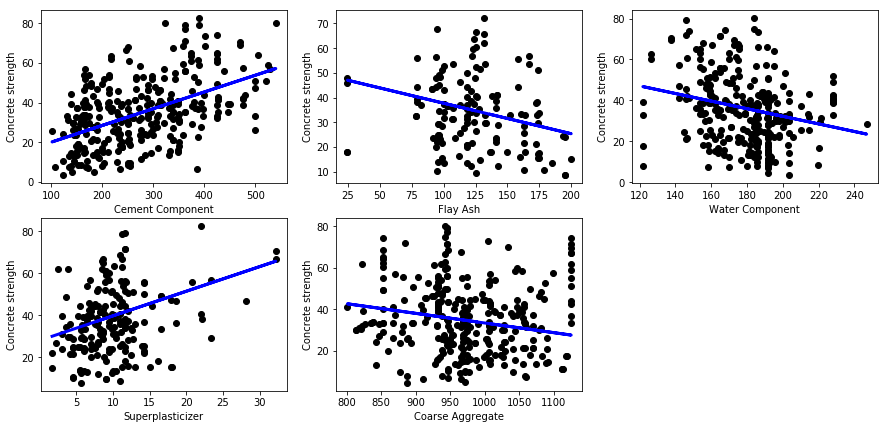

In [101]:
#Calculating Single Support Vector Machine Regression Using Linear Kernel
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    # Create linear regression object
    regr = SVR(kernel='linear')
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

C:\Users\LTD\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: -0.017503


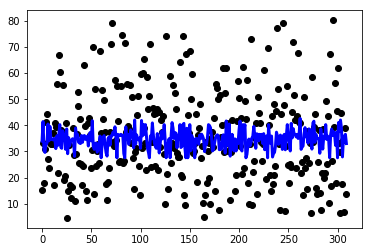

In [102]:
#Calculating Multiple Support Vector Machine Regression Using LinearKernel
model = SVR(kernel='linear')
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))